In [ ]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip

!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data


In [ ]:
import numpy as np
import os
from matplotlib import pyplot as plt
import math

In [ ]:
BASE_PATH = "data"
WORD_LIST = []

WORDS = open(f"{BASE_PATH}/words.txt", "r").readlines()

for line in WORDS:
  if line[0] == "#":
    continue

  if line.split(" ")[1] != "err":
    WORD_LIST.append(line)

len(WORD_LIST)

96456

In [ ]:
split_idx = int(0.9 * len(WORD_LIST))
train_samples = WORD_LIST[:split_idx]
test_samples = WORD_LIST[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(WORD_LIST) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total training samples: {len(validation_samples)}")
print(f"Total training samples: {len(test_samples)}")

Total training samples: 86810
Total training samples: 4823
Total training samples: 4823


In [ ]:
BASE_IMAGE_PATH = os.path.join(BASE_PATH, "words")

In [ ]:
def get_image_paths_labels(samples):
  paths = []
  corrected_samples = []
  for (i, file_line) in enumerate(samples):
    line_split = file_line.strip()
    line_split = line_split.split(" ")

    image_name = line_split[0]
    part1 = image_name.split('-')[0]
    part2 = image_name.split('-')[1]
    img_path = os.path.join(BASE_IMAGE_PATH, part1, part1+"-"+part2, image_name+".png")

    if os.path.getsize(img_path):
      paths.append(img_path)
      corrected_samples.append(file_line.split("\n")[0])
    
  return paths, corrected_samples

In [ ]:
train_image_paths, train_labels = get_image_paths_labels(train_samples)
validation_image_paths, validation_labels = get_image_paths_labels(validation_samples)
test_image_paths, test_labels = get_image_paths_labels(test_samples)

In [ ]:
def get_characters_maxlen(train_labels):
  train_labels_cleaned = []
  characters = set()
  max_len = 0

  for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
      characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

  characters = sorted(list(characters))

  return characters, max_len, train_labels_cleaned

In [ ]:
CHARACTERS, MAX_LEN, train_labels_cleaned = get_characters_maxlen(train_labels)

print("Maximum length :", MAX_LEN)
print("VOCAB size :", len(CHARACTERS))

Maximum length : 21
VOCAB size : 78


In [ ]:
train_labels_cleaned[:5]

['A', 'MOVE', 'to', 'stop', 'Mr.']

In [ ]:
def clean_labels(labels):
  cleaned_labels = []
  for label in labels:
    label = label.split(" ")[-1].strip()
    cleaned_labels.append(label)
  return cleaned_labels

In [ ]:
validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

AUTOTUNE = tf.data.AUTOTUNE

char_to_num = StringLookup(vocabulary=list(CHARACTERS), mask_token=None)

num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [ ]:
def distortion_free_resize(image, img_size):
  w, h  = img_size
  image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

  pad_height = h - tf.shape(image)[0]
  pad_width = w - tf.shape(image)[1]

  if pad_height % 2 != 0:
    height = pad_height // 2
    pad_height_top = height + 1
    pad_height_bottom = height
  else:
    pad_height_top = pad_height_bottom = pad_height // 2

  if pad_width % 2 != 0:
    width = pad_width // 2
    pad_width_left = width + 1
    pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_width // 2
  
  image = tf.pad(image, paddings=[[pad_height_top, pad_height_bottom],
                                  [pad_width_left, pad_width_right],
                                  [0,0]])
  
  image = tf.transpose(image, perm=[1,0,2])
  image = tf.image.flip_left_right(image)
  return image


In [ ]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 32
PADDING_TOKEN = 99
BATCH_SIZE = 64

In [ ]:
def preprocess_image(image_path, img_size=(IMAGE_WIDTH, IMAGE_HEIGHT)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = distortion_free_resize(image, img_size)
  image = tf.cast(image, tf.float32) / 255.0
  return image

In [ ]:
def vectorize_label(label):
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  length = tf.shape(label)[0]
  pad_amount = MAX_LEN - length
  label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=PADDING_TOKEN)
  return label

In [ ]:
def process_images_labels(image_path, label):
  image = preprocess_image(image_path)
  label = vectorize_label(label)
  return {"image": image, "label": label}

In [ ]:
def prepare_dataset(image_paths, labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(process_images_labels, num_parallel_calls=AUTOTUNE)
  return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [ ]:
train_dataset = prepare_dataset(train_image_paths, train_labels_cleaned)
validation_dataset = prepare_dataset(validation_image_paths, validation_labels_cleaned)
test_dataset = prepare_dataset(test_image_paths, test_labels_cleaned)

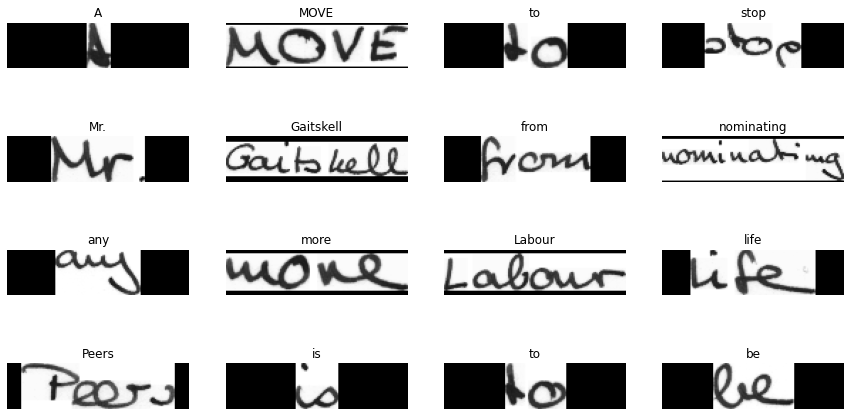

In [ ]:
for data in train_dataset.take(1):
  images, labels = data["image"], data["label"]
  _, ax = plt.subplots(4, 4, figsize=(15, 8))

  for i in range(16):
    img = images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1,0,2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:,:,0]

    label = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, PADDING_TOKEN)))
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")

plt.show()


In [ ]:
import keras

class CTCLayer(keras.layers.Layer):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)
    
    return y_pred

In [ ]:
from keras.layers import Input, Bidirectional, Conv2D, BatchNormalization, MaxPooling2D, Flatten, LSTM, Dense, Activation, Dropout, Reshape

def build_model_1():
  # Inputs to the model
  input_img = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), name="image")
  labels = Input(name="label", shape=(None,))

  # First conv block.
  x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", 
             padding="same", name="Conv1", )(input_img)
  x = MaxPooling2D((2, 2), name="pool1")(x)

  # Second conv block.
  x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", 
             padding="same", name="Conv2",)(x)
  x = MaxPooling2D((2, 2), name="pool2")(x)

  # We have used two max pool with pool size and strides 2.
  # Hence, downsampled feature maps are 4x smaller. The number of
  # filters in the last layer is 64. Reshape accordingly before
  # passing the output to the RNN part of the model.
  new_shape = ((IMAGE_WIDTH // 4), (IMAGE_HEIGHT // 4) * 64)
  x = Reshape(target_shape=new_shape, name="reshape")(x)
  x = Dense(64, activation="relu", name="dense1")(x)
  x = Dropout(0.2)(x)

  # RNNs.
  x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)
  x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25))(x)

  # +2 is to account for the two special tokens introduced by the CTC loss.
  x = Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)

  # Add CTC layer for calculating CTC loss at each step.
  output = CTCLayer(name="ctc_loss")(labels, x)

  # Define the model.
  model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="handwriting_recognizer")

  # Optimizer.
  opt = tf.keras.optimizers.Adam()

  # Compile the model and return.
  model.compile(optimizer=opt)

  return model

In [ ]:
def build_model_2(lstm_layers=5, lstm_units=128, lstm_dropout=0.25):
  input_img = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), name="image")
  labels = Input(name="label", shape=(None,))

  conv = Conv2D(filters=64, kernel_size=(1, 1), activation='relu', kernel_initializer='he_normal')(input_img)
  bn = BatchNormalization()(conv)
  conv = Conv2D(filters=64, kernel_size=(1, 1), activation='relu', kernel_initializer='he_normal')(bn)
  bn = BatchNormalization()(conv)
  pooling = MaxPooling2D(pool_size=(2,2))(bn)

  conv = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', kernel_initializer='he_normal')(pooling)
  bn = BatchNormalization()(conv)
  conv = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', kernel_initializer='he_normal')(bn)
  bn = BatchNormalization()(conv)
  pooling = MaxPooling2D(pool_size=(2,2))(bn)

  conv = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', kernel_initializer='he_normal')(pooling)
  bn = BatchNormalization()(conv)
  conv = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', kernel_initializer='he_normal')(bn)
  bn = BatchNormalization()(conv)
  conv = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', kernel_initializer='he_normal')(bn)
  bn = BatchNormalization()(conv)
  pooling = MaxPooling2D(pool_size=(2,1))(bn)

  conv = Conv2D(filters=512, kernel_size=(1, 1), activation='relu', kernel_initializer='he_normal')(pooling)
  bn = BatchNormalization()(conv)
  conv = Conv2D(filters=512, kernel_size=(1, 1), activation='relu', kernel_initializer='he_normal')(bn)
  bn = BatchNormalization()(conv)
  conv = Conv2D(filters=512, kernel_size=(1, 1), activation='relu', kernel_initializer='he_normal')(bn)
  bn = BatchNormalization()(conv)
  pooling = MaxPooling2D(pool_size=(2,1))(bn)

  conv = Conv2D(filters=512, kernel_size=(1, 1), activation='relu', kernel_initializer='he_normal')(pooling)
  bn = BatchNormalization()(conv)
  conv = Conv2D(filters=512, kernel_size=(1, 1), activation='relu', kernel_initializer='he_normal')(bn)
  bn = BatchNormalization()(conv)
  conv =Conv2D(filters=512, kernel_size=(1, 1), activation='relu', kernel_initializer='he_normal')(bn)
  bn = BatchNormalization()(conv)
  pooling = MaxPooling2D(pool_size=(2,1))(bn)


  LastFilters = 512	
  x = Reshape(target_shape=(LastFilters * 2, 16))(pooling)
  x = keras.layers.Dropout(0.2)(x)

  for i in range(1, lstm_layers + 1):
      lstm = LSTM(
          lstm_units,
          return_sequences=True, 
          dropout=lstm_dropout,
          name=f"gru_{i}",)
      x = Bidirectional(lstm, name=f"bidirectional_{i}")(x)

  
  x = Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)

  output = CTCLayer(name="ctc_loss")(labels, x)

  model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="handwriting_recognizer")

  optimizer = tf.keras.optimizers.Adam()

  model.compile(optimizer=optimizer)

  return model

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

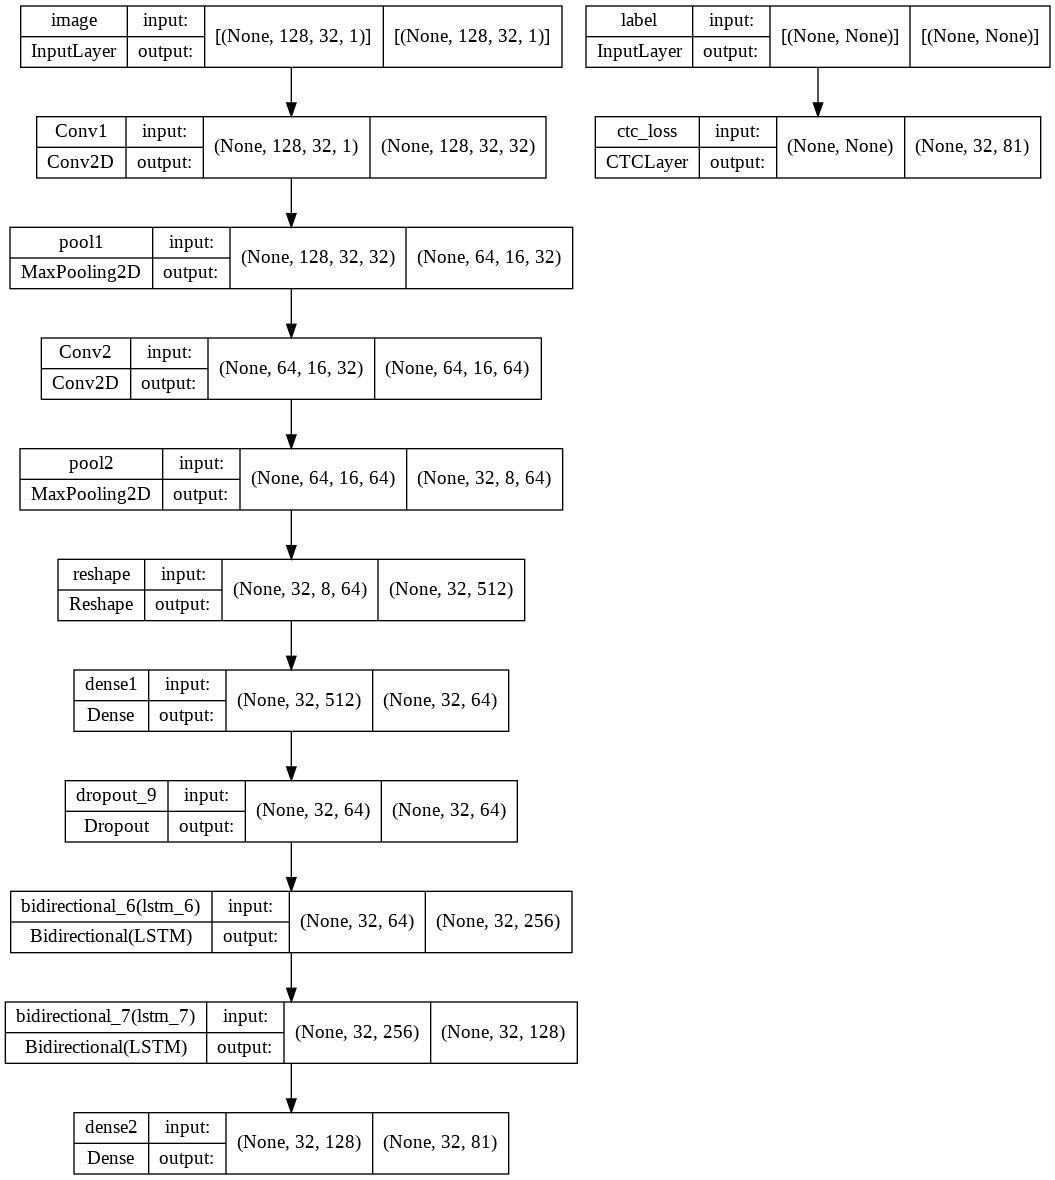

In [ ]:
model = build_model_1()

model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_dataset:
  validation_images.append(batch["image"])
  validation_labels.append(batch["label"])

In [ ]:
def calculate_edit_distance(labels, predictions):
  # Get a single batch and convert its labels to sparse tensors.
  saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

  # Make predictions and convert them to sparse tensors.
  input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
  predictions_decoded = keras.backend.ctc_decode(predictions, input_length=input_len, greedy=True)[0][0][:, :MAX_LEN]
  sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded), dtype=tf.int64)

  # Compute individual edit distances and average them out.
  edit_distances = tf.edit_distance(sparse_predictions, saprse_labels, normalize=False)
  return tf.reduce_mean(edit_distances)

In [ ]:
class EditDistanceCallback(keras.callbacks.Callback):
  def __init__(self, pred_model):
    super().__init__()
    self.prediction_model = pred_model

  def on_epoch_end(self, epoch, logs=None):
    edit_distances = []

    for i in range(len(validation_images)):
      labels = validation_labels[i]
      predictions = self.prediction_model.predict(validation_images[i])
      edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

    print(f"\nMean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}")

In [ ]:
epochs = 50  

prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)

edit_distance_callback = EditDistanceCallback(prediction_model)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


Epoch 1/50
1357/1357 [==============================] - ETA: 0s - loss: 14.1997
Mean edit distance for epoch 1: 20.6348
1357/1357 [==============================] - 131s 92ms/step - loss: 14.1997 - val_loss: 10.8014
Epoch 2/50
1357/1357 [==============================] - ETA: 0s - loss: 11.9350
Mean edit distance for epoch 2: 20.3483
1357/1357 [==============================] - 68s 50ms/step - loss: 11.9350 - val_loss: 9.1869
Epoch 3/50
1357/1357 [==============================] - ETA: 0s - loss: 10.2903
Mean edit distance for epoch 3: 20.0907
1357/1357 [==============================] - 69s 51ms/step - loss: 10.2903 - val_loss: 7.7565
Epoch 4/50
1356/1357 [============================>.] - ETA: 0s - loss: 8.8019
Mean edit distance for epoch 4: 19.7777
1357/1357 [==============================] - 69s 51ms/step - loss: 8.8013 - val_loss: 6.2988
Epoch 5/50
1356/1357 [============================>.] - ETA: 0s - loss: 7.2593
Mean edit distance for epoch 5: 19.2256
1357/1357 [==============

In [ ]:
def decode_batch_predictions(pred):
  input_len = np.ones(pred.shape[0]) * pred.shape[1]

  # Use greedy search. For complex tasks, you can use beam search.
  results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :MAX_LEN]

  # Iterate over the results and get back the text.
  output_text = []
  for res in results:
    res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
    res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
    output_text.append(res)

  return output_text

['sounded', 'like', 'some-', 'body', 'etse', 'for', 'a', 'moment', 'there', '.', 'It', "deesn't", 'become', 'you', 'to', 'behave', 'Wihe', 'a', '-', 'a', 'tart', '.', 'Dr', '.', '"', '"', 'Nigad', '-', '!', '"', 'she', 'gasped', '.', '"', 'i', "didn't", 'mean', 'to', 'behave', 'like', 'anything', 'of', 'the', 'aind', '.', 'I', 'miserable', 'enough', 'wy', 'having', 'to', 'take', 'my', 'leave', 'in', 'the', 'antumn', 'without', 'you', 'tying', 'to', 'be', 'bright', 'and']
['sounded', 'like', 'some-', 'body', 'etse', 'for', 'a', 'moment', 'there', '.', 'It', "deesn't", 'become', 'you', 'to', 'behave', 'Wihe', 'a', '-', 'a', 'tart', '.', 'Dr', '.', '"', '"', 'Nigad', '-', '!', '"', 'she', 'gasped', '.', '"', 'i', "didn't", 'mean', 'to', 'behave', 'like', 'anything', 'of', 'the', 'aind', '.', 'I', 'miserable', 'enough', 'wy', 'having', 'to', 'take', 'my', 'leave', 'in', 'the', 'antumn', 'without', 'you', 'tying', 'to', 'be', 'bright', 'and']
['sounded', 'like', 'some-', 'body', 'etse', 'fo

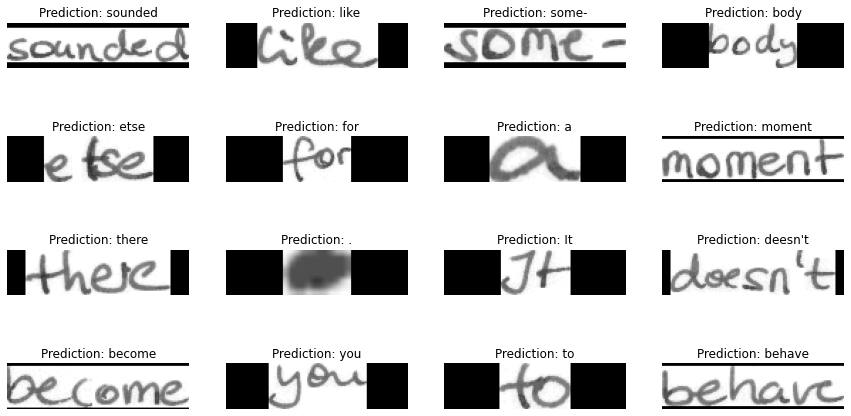

In [ ]:
for batch in test_dataset.take(1):
  batch_images = batch["image"]
  _, ax = plt.subplots(4, 4, figsize=(15, 8))

  preds = prediction_model.predict(batch_images)
  pred_texts = decode_batch_predictions(preds)

  for i in range(16):
    img = batch_images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    print(pred_texts)

    title = f"Prediction: {pred_texts[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")

plt.show()